# Train CUB-200-2011 dataset using towhee

# 1.Prepare the dataset

The **[Caltech-UCSD Birds-200-2011 (CUB-200-2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html)** dataset is the most widely-used dataset for fine-grained visual categorization task.
* Number of categories: 200
* Number of images: 11,788
* Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

And here is a [Benchmarks](https://paperswithcode.com/dataset/cub-200-2011) about this dataset you can refer to.
First, you should download it to your local path from [Images and annotations](https://drive.google.com/file/d/1hbzc_P1FuxMkcabkgn9ZKinBwW683j45/view).
When you downloaded it, you can see this structure.
```
├── 1.jpg
├── 2.jpg
├── 3.jpg
├── README.md
└── data
    ├── CUB_200_2011.tgz
    └── segmentations.tgz
```
Just extract `CUB_200_2011.tgz` and rename folder `images` to `images_orig`.

    cd data
    tar zxvf CUB_200_2011.tgz
    cd CUB_200_2011
    mv images images_orig
    pwd

```
/path/to/your/dataset/Birds-200-2011/data/CUB_200_2011
```
**Use this path as your `root_dir`.**

In [2]:
# root_dir = '/path/to/your/dataset/Birds-200-2011/data/CUB_200_2011'
root_dir = '/home/zhangchen/zhangchen_workspace/dataset/caltech-ucsd-bird-200-2011/Caltech-UCSD Birds-200-2011/data/CUB_200_2011'
# root_dir = '/Users/zilliz/dataset/Caltech-UCSD Birds-200-2011/data/CUB_200_2011'

Loads the image files paths with image_ID (images.txt), and train_test_split.txt designation into Pandas Dataframes for later use.

In [3]:
import os
import pandas as pd

orig_images_folder = 'images_orig'
new_images_folder = 'images'

image_fnames = pd.read_csv(filepath_or_buffer=os.path.join(root_dir, 'images.txt'),
                           header=None,
                           delimiter=' ',
                           names=['Img ID', 'file path'])

image_fnames['is training image?'] = pd.read_csv(filepath_or_buffer=os.path.join(root_dir, 'train_test_split.txt'),
                                                 header=None, delimiter=' ',
                                                 names=['Img ID', 'is training image?'])['is training image?']
# image_fnames.head()

,Img ID,file path,is training image?
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1


Let's modify the dataset files structure to pytorch [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) form. Which is a common way of organizing image files in deep learing.


In [4]:
# data_dir = os.path.join(root_dir, orig_images_folder)
# new_data_dir = os.path.join(root_dir, new_images_folder)
# os.makedirs(os.path.join(new_data_dir, 'train'), exist_ok=True)
# os.makedirs(os.path.join(new_data_dir, 'test'), exist_ok=True)
#
# for i_image, image_fname in enumerate(image_fnames['file path']):
#     if image_fnames['is training image?'].iloc[i_image]:
#         new_dir = os.path.join(new_data_dir, 'train', image_fname.split('/')[0])
#         os.makedirs(new_dir, exist_ok=True)
#         shutil.copy(src=os.path.join(data_dir, image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))
#     else:
#         new_dir = os.path.join(new_data_dir, 'test', image_fname.split('/')[0])
#         os.makedirs(new_dir, exist_ok=True)
#         shutil.copy(src=os.path.join(data_dir, image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))
# print('prepare dataset structure done.')

Using the train_test_split.txt file, each image is copied either to the relevant folder in either the train or test folders. The resulting file will have the following structure:
```
images-|
    train-|
        #classname1#-|
            image-1.jpg
            image-2.jpg
        #classname2-|
            image-1.jpg
            image-2.jpg
        |
        |
        #classnameN-|
            image-1.jpg
            image-2.jpg
    test-|
        #classname1#-|
            image-1.jpg
            image-2.jpg
        #classname2-|
            image-1.jpg
            image-2.jpg
        |
        |
        #classnameN-|
            image-1.jpg
            image-2.jpg
```


# 2.Visualise some input data
Using some utils in towhee, you can watch the images on your dataset as long as your dataset is in the pytorch [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) form of organization.

In [5]:
import os

data_dir = os.path.join(root_dir, 'images')
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

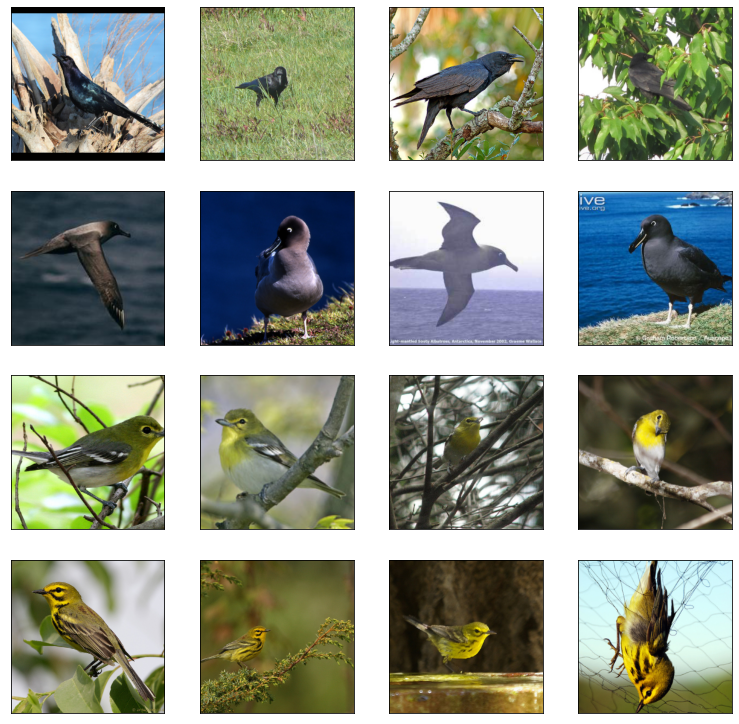

In [6]:
from towhee.trainer.utils.plot_utils import image_folder_sample_show, image_folder_statistic

image_folder_sample_show(train_data_dir, rows=4, cols=4, img_size=255)

You can also watch the image count number of each class.

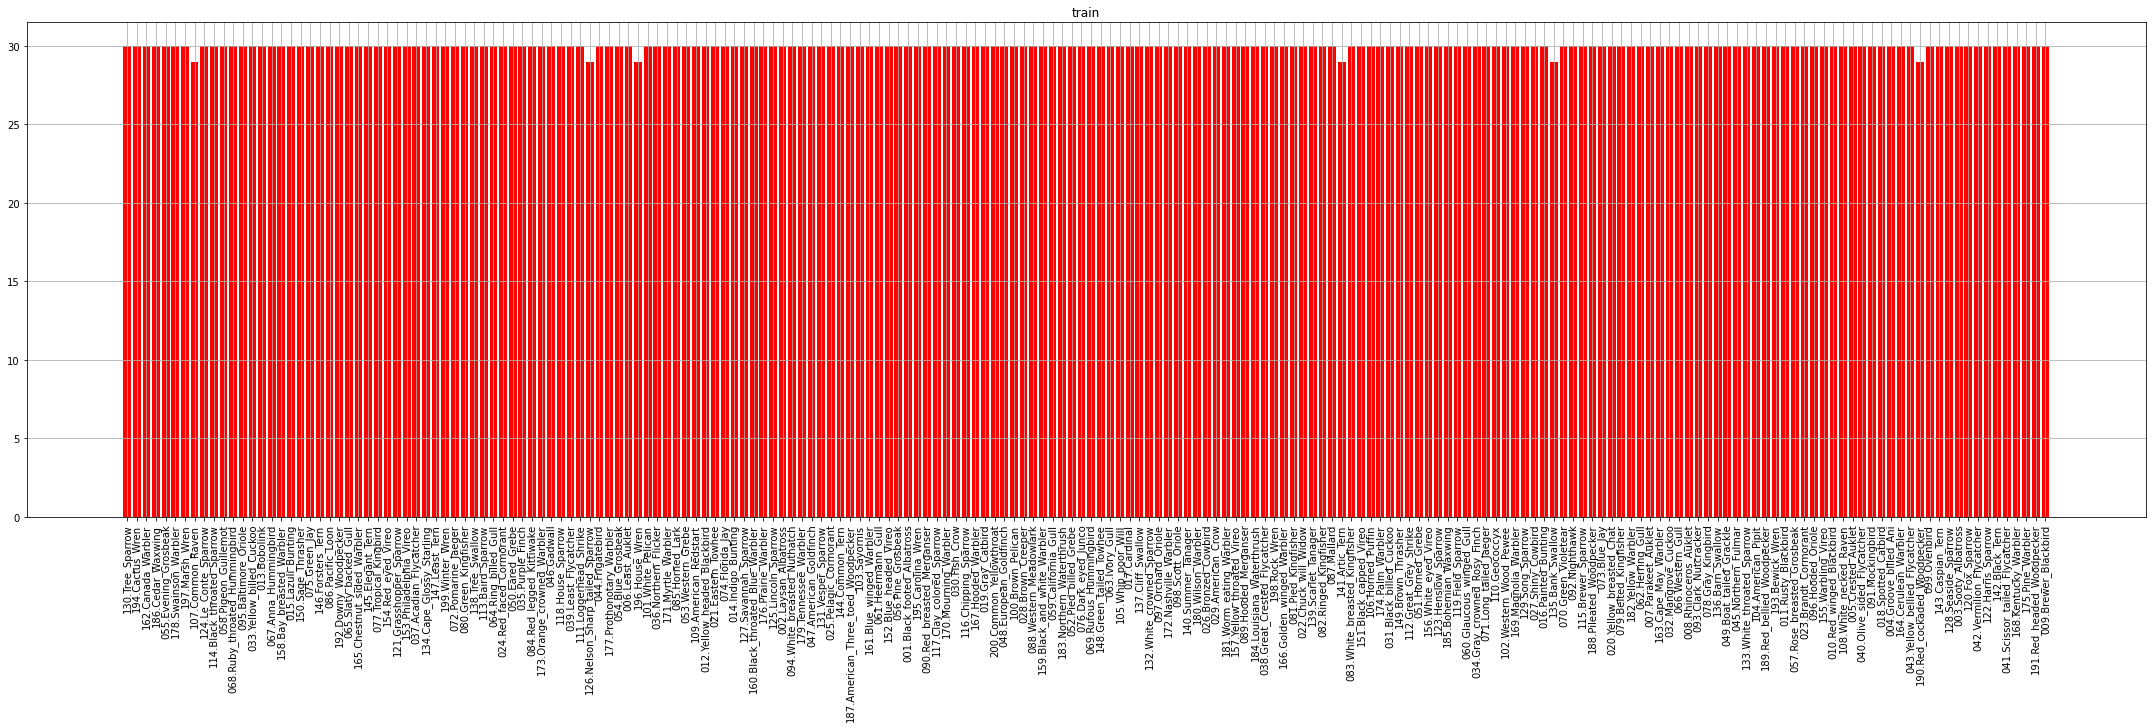

In [7]:
from towhee.trainer.utils.plot_utils import image_folder_statistic

train_cls_count_dict = image_folder_statistic(train_data_dir, show_bar=True)

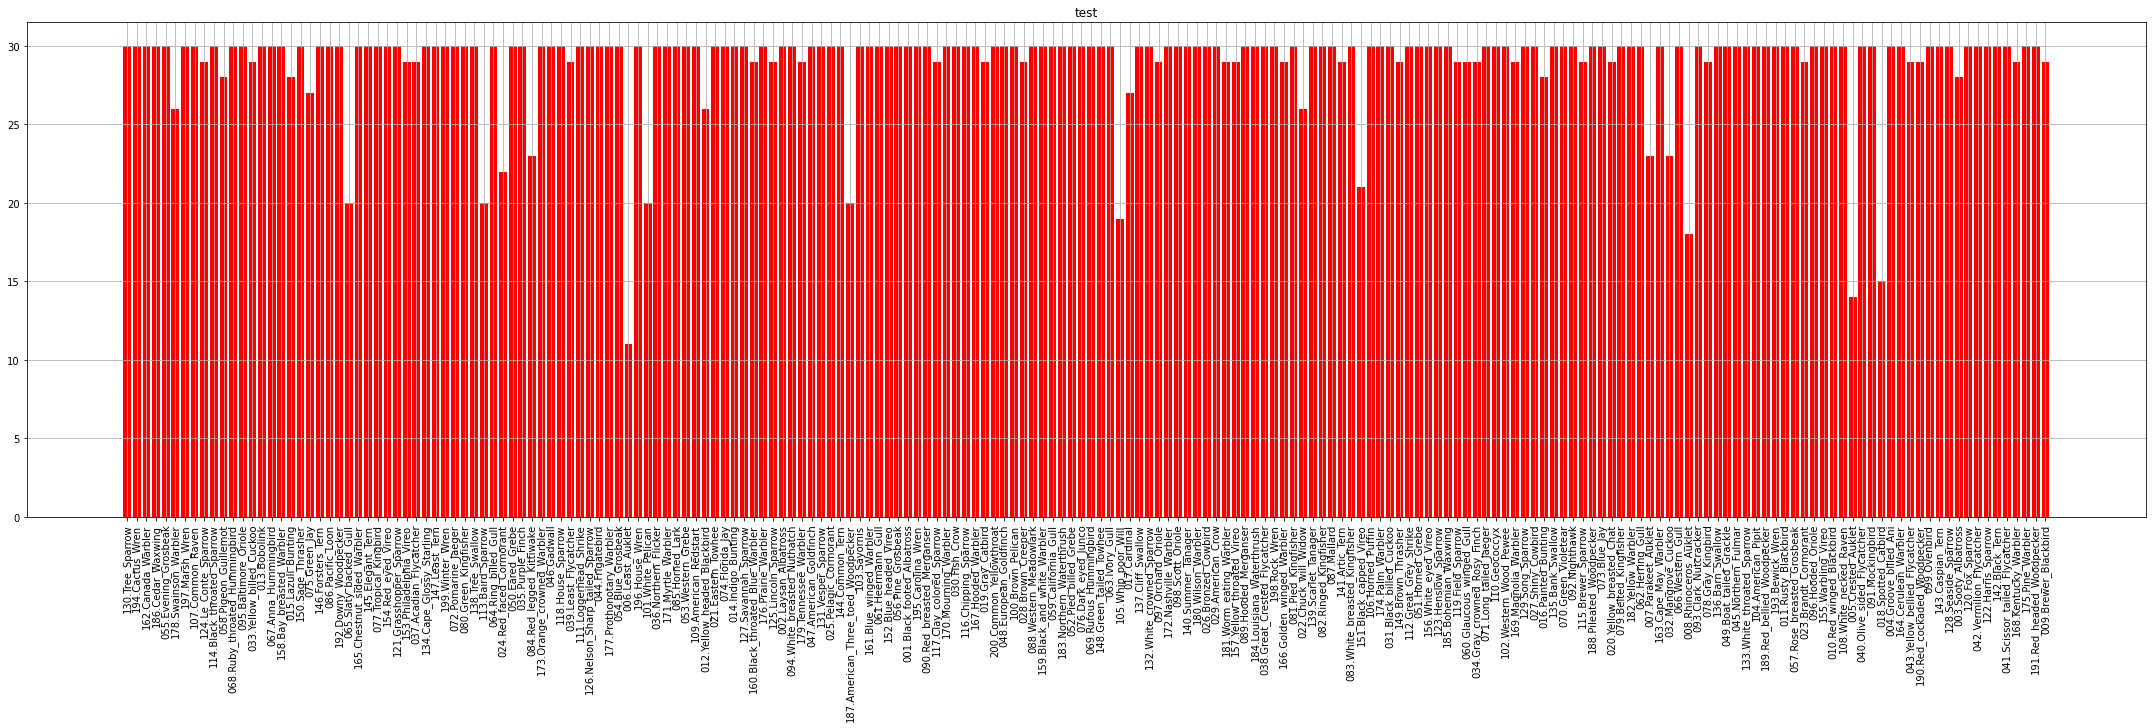

In [8]:
test_cls_count_dict = image_folder_statistic(test_data_dir, show_bar=True)

We found the count number of each class is not balanced, which makes training some difficult.

# 3.Setup your training config.
Setup your custom training configs.

In [9]:
from towhee.trainer.training_config import TrainingConfig

training_config = TrainingConfig()

You can plot the trend chart of lr in the config. The `lr_scheduler_type` can be `linear`, `cosine`, `polynomial`, `constant` or with warmup.

#### linear

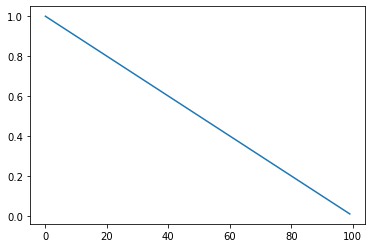

In [10]:
from towhee.trainer.utils.plot_utils import plot_lrs_for_config

training_config.lr_scheduler_type = 'linear'
plot_lrs_for_config(training_config, num_training_steps=100, start_lr=1)

#### cosine

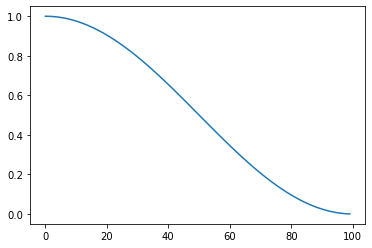

In [11]:
training_config.lr_scheduler_type = 'cosine'
plot_lrs_for_config(training_config, num_training_steps=100, start_lr=1)

#### constant

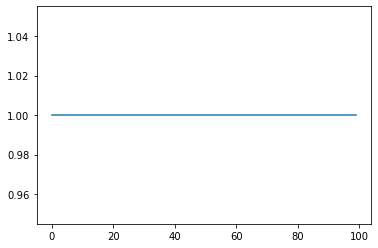

In [12]:
training_config.lr_scheduler_type = 'constant'
plot_lrs_for_config(training_config, num_training_steps=100, start_lr=1)

#### cosine with warm up

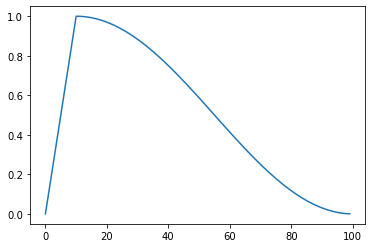

In [13]:
training_config.lr_scheduler_type = 'cosine'
training_config.warmup_ratio = 0.1
plot_lrs_for_config(training_config, num_training_steps=100, start_lr=1)

#### custom lr scheduler
If you want to use pytorch native lr scheduler to custom your lr, you can use `plot_lrs_for_scheduler()` to previously plot it.

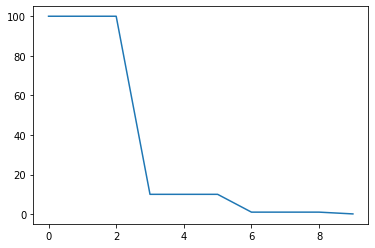

In [14]:
from towhee.trainer.utils.plot_utils import plot_lrs_for_scheduler
from torch import nn
import torch
from torch.optim.lr_scheduler import StepLR

model = nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=100)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
plot_lrs_for_scheduler(optimizer, lr_scheduler, total_steps=10)

In this figure, we use `StepLR` in pytorch to custom our lr. If we want to use this lr schedule in towhee, how to config it, we just set `lr_scheduler_type` to a dict, in which `name_` is the class constructor in the `torch.optim.lr_scheduler` module, other key-values are the parameters in this constructor.
So we use `plot_lrs_for_config()` to plot the lrs in config, we found the two figures are the same. It means we config it rightly.

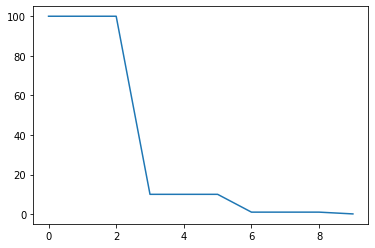

In [15]:
training_config.lr_scheduler_type = {
    'name_': 'StepLR',
    'step_size': 3,
    'gamma': 0.1
}
plot_lrs_for_config(training_config, num_training_steps=10, start_lr=100)

By this way, the dict in config field can be converted in both directions with yaml. Though we can't configure python object inside yaml file, we can use this method to configure most of the lr scheduler and optimizer.
Take optimizer for example, if we want config the custom SGD optimzer, it can be handled in the same way.

In [16]:
torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# equals
training_config.optimizer = {
    'name_': 'SGD',
    'lr': 0.1,
    'momentum': 0.9
}

For more config and yaml information, see [training_configs].
Now let's specify the training_config in this task.

In [17]:
training_config = TrainingConfig(
    batch_size=16,
    epoch_num=50,
    device_str='cuda:3',  # if 'cuda', use all of gpus. if 'cuda:0', use No.0 gpu.
    dataloader_num_workers=8,
    output_dir='cub_200_output',
    lr_scheduler_type='cosine',
    optimizer='Adam'
)

 In this example, we set epoch_num=50, but it will be early stopped by the default early stop callback with 4 epoch patients. The if you want to use all of gpus in your device, set `device_str=cuda`.You can also use one gpu by specifying the device id, such as `device_str='cuda:2'`.
Pay attention, if you train with multi gpus, you should reload the weights from the output dir to do custom test and evaluation.

# 4.Define data transforms.
Data augmentation can be done during training with data transforms, let's define a `data_transforms` dict about train and test period, where std and mean is calculated from ImageNet.

In [18]:
from torchvision import transforms

std = (0.229, 0.224, 0.229)
mean = (0.485, 0.456, 0.406)


def resizeCropTransforms(img_crop_size=224, img_resize=256):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(img_resize),
            transforms.CenterCrop(img_crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            # transforms.RandomHorizontalFlip(p=0.5)
        ]),
        'test': transforms.Compose([
            transforms.Resize(img_resize),
            transforms.CenterCrop(img_crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }
    return data_transforms

Then we can use it to define the training data and evaluation data.

In [19]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

train_transform = resizeCropTransforms(img_resize=256, img_crop_size=224)['train']
val_transform = resizeCropTransforms(img_resize=256, img_crop_size=224)['test']
train_data = ImageFolder(train_data_dir, transform=train_transform)
eval_data = ImageFolder(test_data_dir, transform=val_transform)

We can plot the transforms images to intuitively feel the impact of image transformation on training.

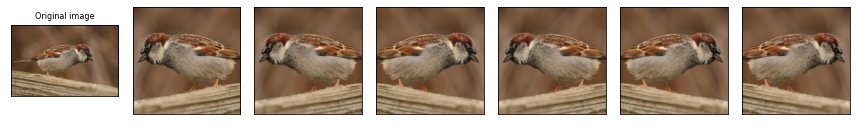

In [20]:
from towhee.trainer.utils.plot_utils import show_transform

img_path = os.path.join(train_data_dir, '118.House_Sparrow', 'House_Sparrow_0006_111034.jpg')

show_transform(
    image_path=img_path,
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.ToTensor(),
        # transforms.Normalize(mean, std)
    ]))

# show_transform(img_path, resizeCropTransforms()['train'])

# 5. Start to train
With all things prepared, you just need to run `train()` method.

In [21]:
import towhee

op = towhee.ops.towhee.timm_image_embedding(model_name='resnext101_32x8d', num_classes=200)
# op2 = towhee.ops.towhee.timm_image_embedding(model_name='resnet152', num_classes=200)

op.train(training_config, train_dataset=train_data, eval_dataset=eval_data)

2022-03-24 10:31:08,917 - 139710037235520 - trainer.py-trainer:319 - WARNING: TrainingConfig(output_dir='cub_200_output', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=16, val_batch_size=-1, seed=42, epoch_num=50, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=8, lr=5e-05, metric='Accuracy', print_steps=None, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': None, 'comment': ''}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='cosine', warmup_ratio=0.0, warmup_steps=0, device_str='cuda:3', sync_bn=False, freeze_bn=False)
[epoch 1/50] loss=3.421, metric=0.382, eval_loss=4.285, eval_metric=0.521: 100%|██████████████████████████████████████████████████| 374/374 [02:04<00:00,  3.01step/s]
[epoch 2/50] loss=1.161, metric=0.807, eval_loss=3.127, eval_metric=0.625: 100%|███████████████████████████

Congratulations, you have successfully trained an operator with towhee